# 超小额用户行为特征抽象建模

> 基于行为分析V2.0结论，对超小额群体进行建模分析，找出逾期用户特征

# 准备阶段

## 加载库

In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn import preprocessing
from scipy.stats import skew, boxcox
import os

from pyecharts import Bar
import mpld3
from mpld3 import plugins

%matplotlib inline

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [414]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

## 导入数据

In [489]:
%store -r petty_data_set

In [562]:
data_set_v0=petty_data_set[petty_data_set.action==1]

In [ ]:
# 数据集扩充和抽样
data_01=pd.concat([data_set_v0[data_set_v0.odu_bid==1]]*10)
data_02=pd.concat([data_set_v0[data_set_v0.odu_bid==0]]*3)


# 合并数据
data_set_v1=pd.concat([data_01,data_02],ignore_index=True)
data_set_v1['odu_bid'].value_counts()

## NULL值处理

In [ ]:
# 先对NUll值
data_set=data_set_v1.fillna(0)

# 分箱的意义

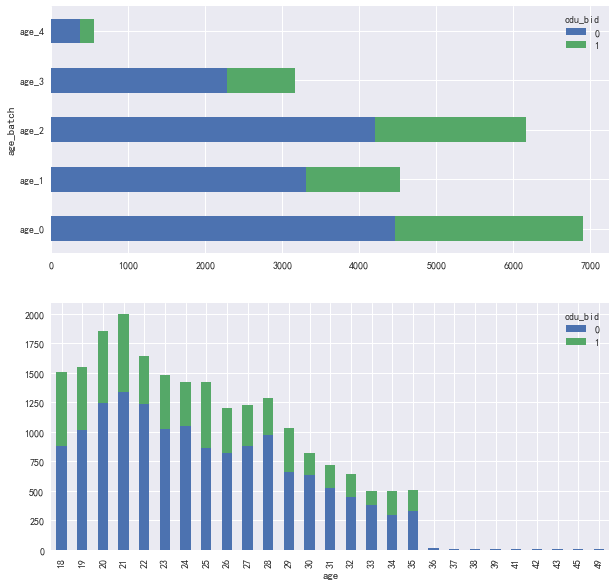

In [681]:
# dataframe画图注意事项
fig, axes = plt.subplots(nrows=2, ncols=1)

var = data_set.groupby(['age_batch','odu_bid']).size()
var.unstack().plot(kind='barh',stacked=True,grid=True,ax=axes[0],figsize=(10,10))


var = data_set.groupby(['age','odu_bid']).bid.count()
var.unstack().plot(kind='bar',stacked=True,grid=True,ax=axes[1],figsize=(10,10))


* 通过分箱处理，分布更加集中

# 连续变量分箱

> **连续变量分箱步骤**

  * 首先筛选出需要分箱的连续变量
  * 计算变量在不同分箱下的iv值，确定每个需要分箱变量最终的分箱数
  * 将已分箱的变量按照分箱重新赋值
  * 删除分箱的变量，保留分箱变量变换后的变量，统一加上 _batch 后缀 

--------------------

> **WOE的基本特点**

  * 当前分组中，逾期的比例越大，WOE值越大；且WOE描述了变量当前分组对判断个体是否会逾期所起到的影响方向和大小。
  * 当前分组WOE的正负，由当前分组响应和未响应的比例与样本整体响应和未响应的比例的大小关系决定
   * 当前分组的比例大于整体比例时，WOE为正；即变量当前取值对判断个体是否会逾期起到的正向的影响
   * 当前分组的比例小于样本整体比例时，WOE为负；即变量当前取值对判断个体是否会逾期起到的负向的影响
   * 当前分组的比例和整体比例相等时，WOE为0
  * WOE的取值范围是全体实数。
  
  
--------------------
> **IV的基本特点**

  * 对于变量的一个分组，这个分组的逾期和未逾期的比例与样本整体逾期和未逾期的比例相差越大，IV值越大，否则，IV值越小；
  * 极端情况下，当前分组的逾期和未逾期应的比例和样本整体的逾期和未逾期的比例相等时，IV值为0；
  * IV值的取值范围是[0,+∞)，且，当当前分组中只包含逾期用户或者未逾期用户时，IV = +∞。

--------------------

> **IV 值的选择**

  * < 0.02 ： 无预测能力
  * 0.02 ~ 0.1 ： 较弱的预测能力
  * 0.1 ~ 0.3 : 预测能力一般
  * 0.3 ~ 0.5 : 较强的预测能力
  * \> 0.5 : 可疑 
  * IV无论等于 $+∞$ 还是 $-∞$，都是没有意义的。

In [492]:
# Y标签
Y_col=data_set['odu_bid']

In [ ]:
#3.1、数据分箱后批量替换原始变量
a=[18,22,25,30,35]
col_vars=['age']
for col in col_vars:
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
            data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_batch']=col+'_'+str(i)
        elif i==max(range(len(np.unique(a)))):
            data_set.loc[data_set[col]>=a[i],col+'_batch']=col+'_'+str(i)

## 等分位数

In [493]:
def calciv_equal_percent(X_col,Y_col,k,point):
    a=[0 for i in range(k)]
    for i in range(k):
        a[i]=stats.scoreatpercentile(X_col, i*point) # point <= 100/(k-1) 
    woe=np.zeros(np.unique(a).shape)
    iv=np.zeros(np.unique(a).shape)
    # n_1表示逾期：逾期人数合计
    n_1 = np.sum(Y_col==1)
    n_1_group = np.zeros(np.unique(a).shape)
    # n_0表示未逾期：未逾期人数合计    
    n_0 = np.sum(Y_col==0)
    n_0_group = np.zeros(np.unique(a).shape)
    for i in range(len(np.unique(a))):
        if i < max(range(len(np.unique(a))-1)):
            n_1_group[i] = Y_col[(X_col >= a[i]) & (X_col < a[i+1]) & (Y_col == 1)].count()
            n_0_group[i] = Y_col[(X_col >= a[i]) & (X_col < a[i+1]) & (Y_col == 0)].count()
            woe[i] = np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
            iv[i] = (np.sum(n_1_group[i])/n_1-np.sum(n_0_group[i])/n_0)*np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
        elif i==len(np.unique(a))-1:
            n_1_group[i] = Y_col[(X_col >= a[i]) & (Y_col == 1)].count()
            n_0_group[i] = Y_col[(X_col >= a[i]) & (Y_col == 0)].count()
            woe[i] = np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
            iv[i] = (np.sum(n_1_group[i])/n_1-np.sum(n_0_group[i])/n_0)*np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
    IV=sum(iv)
    return  IV,woe

### 单变量IV值和WOE值

In [494]:
#批量筛选需要手动设置cutpoint的变量
# zxhouseloancnt
# ,'zxaccountcnt','bidnormalscoreexp3v2','prcidnormalscoreexp3v2','phonenormalscoreexp3v2'
col_vars=['jiedaiscore']

#批量计算iv值，k=5,point=10
k=5
point=10
col_iv_value=[]
col_woe_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_equal_percent(data_set[col],Y_col,k,point)[0],3))  
    col_woe_value.append(calciv_equal_percent(data_set[col],Y_col,k,point)[1])


# calciv_equal_percent(data_set['jiedaiscore'],Y_col,k,point)

In [ ]:
# 查看分箱后的变量IV值
num_iv_dict=dict(zip(col_iv_value,col_woe_value))
num_iv_dict

### 分箱变量衍生

#### 直接用无量纲标识分箱结果

In [454]:
a=[0]*k  # k=5
for col in col_vars:
    for i in range(k):   # k=5
        a[i]=stats.scoreatpercentile(data_set[col], point*i)  # point =10
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
             data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_batch']=col+'_'+str(i)
        elif i==max(range(len(np.unique(a)))):
             data_set.loc[data_set[col]>=a[i],col+'_batch']=col+'_'+str(i)

#### 用分箱后的woe值衍生

In [495]:
a=[0]*k  # k=5
for col in col_vars:
    for i in range(k):   # k=5
        a[i]=stats.scoreatpercentile(data_set[col], point*i)  # point =10
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
             data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_woe']=calciv_equal_percent(data_set[col],Y_col,k,point)[1][i]
        elif i==max(range(len(np.unique(a)))):
             data_set.loc[data_set[col]>=a[i],col+'_woe']=calciv_equal_percent(data_set[col],Y_col,k,point)[1][i]

## 手动切分

In [499]:
# 定义手动切分区间
def calciv_set_cutpoints(X_col,Y_col):
    woe=np.zeros(np.unique(a).shape)
    iv=np.zeros(np.unique(a).shape)
    n_0 = np.sum(Y_col==0)
    n_1 = np.sum(Y_col==1)
    n_0_group = np.zeros(np.unique(a).shape)
    n_1_group = np.zeros(np.unique(a).shape)
    np.unique(a).sort()
    for i in range(len(np.unique(a))):
        if i < max(range(len(np.unique(a))-1)):
            n_0_group[i] = Y_col[(X_col >= a[i]) & (X_col < a[i+1]) & (Y_col == 0)].count()
            n_1_group[i] = Y_col[(X_col >= a[i]) & (X_col < a[i+1]) & (Y_col == 1)].count()
            woe[i]=np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
            iv[i] = (np.sum(n_1_group[i])/n_1-np.sum(n_0_group[i])/n_0)*np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
        elif i==len(np.unique(a))-1:
            n_0_group[i] = Y_col[(X_col >= a[i]) & (Y_col == 0)].count()
            n_1_group[i] = Y_col[(X_col >= a[i]) & (Y_col == 1)].count()
            woe[i]=np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
            iv[i] = (np.sum(n_1_group[i])/n_1-np.sum(n_0_group[i])/n_0)*np.log(((np.sum(n_1_group[i])/n_1)/(np.sum(n_0_group[i])/n_0)))
    IV=sum(iv)
    return  IV,woe

In [ ]:
# 需要手动分箱的变量和切分区间
a=[10,15,20,25,30]
col_vars=['phonenormalscoreexp3v2']

# 计算IV值
col_iv_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_set_cutpoints(data_set[col],Y_col)[0],2))

print col_iv_value
print calciv_set_cutpoints(data_set[col],Y_col)


#3.1、数据分箱后批量替换原始变量
for col in col_vars:
    a=[10,15,20,25,30]
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
            data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]
        elif i==max(range(len(np.unique(a)))):
            data_set.loc[data_set[col]>=a[i],col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]

### age

#### 单变量IV值

In [507]:
# 需要手动分箱的变量和切分区间
a=[18,22,25,30,35]
col_vars=['age']

# 计算IV值
col_iv_value=[]
col_woe_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_set_cutpoints(data_set[col],Y_col)[0],2))
    col_woe_value.append(calciv_set_cutpoints(data_set[col],Y_col)[1])

#### 用分箱后的woe值衍生

In [510]:
#3.1、数据分箱后批量替换原始变量
for col in col_vars:
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
            data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]
        elif i==max(range(len(np.unique(a)))):
            data_set.loc[data_set[col]>=a[i],col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]

### zxaccount

#### 单变量IV值

In [ ]:
# 需要手动分箱的变量和切分区间
a=[0,1,5]
col_vars=['zxaccountcnt']

# 计算IV值
col_iv_value=[]
col_woe_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_set_cutpoints(data_set_test[col],Y_col)[0],2))
    col_woe_value.append(calciv_set_cutpoints(data_set_test[col],Y_col)[1])

# 查看分箱后的变量IV值
num_iv_dict=dict(zip(col_iv_value,col_woe_value))
num_iv_dict

In [ ]:
# 需要手动分箱的变量和切分区间
a=[1,5]
col_vars=['zxaccountcnt']

# 计算IV值
col_iv_value=[]
col_woe_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_set_cutpoints(data_set[col],Y_col)[0],2))
    col_woe_value.append(calciv_set_cutpoints(data_set[col],Y_col)[1])

# 查看分箱后的变量IV值
num_iv_dict=dict(zip(col_iv_value,col_woe_value))
num_iv_dict

#### 用分箱后的woe值衍生

In [540]:
#3.1、数据分箱后批量替换原始变量
for col in col_vars:
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
            data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]
        elif i==max(range(len(np.unique(a)))):
            data_set.loc[data_set[col]>=a[i],col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]

### mobiledate

#### 单变量IV值

In [ ]:
# 需要手动分箱的变量和切分区间
a=[10,20,30,40]
col_vars=['mobileoperatorregdate']

# 计算IV值
col_iv_value=[]
col_woe_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_set_cutpoints(data_set[col],Y_col)[0],2))
    col_woe_value.append(calciv_set_cutpoints(data_set[col],Y_col)[1])

# 查看分箱后的变量IV值
num_iv_dict=dict(zip(col_iv_value,col_woe_value))
num_iv_dict

#### 用分箱后的woe值衍生

In [538]:
#3.1、数据分箱后批量替换原始变量
for col in col_vars:
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
            data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]
        elif i==max(range(len(np.unique(a)))):
            data_set.loc[data_set[col]>=a[i],col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]

### city_index

#### 单变量IV值

In [ ]:
# 需要手动分箱的变量和切分区间
a=[1,2,3,4,5]
col_vars=['city_idx']

# 计算IV值
col_iv_value=[]
col_woe_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_set_cutpoints(data_set[col],Y_col)[0],2))
    col_woe_value.append(calciv_set_cutpoints(data_set[col],Y_col)[1])
    

# 查看分箱后的变量IV值
num_iv_dict=dict(zip(col_iv_value,col_woe_value))
num_iv_dict

#### 用分箱后的woe值衍生

In [276]:
#3.1、数据分箱后批量替换原始变量
for col in col_vars:
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
            data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]
        elif i==max(range(len(np.unique(a)))):
            data_set.loc[data_set[col]>=a[i],col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]

### education

#### 单变量IV值

In [ ]:
# 需要手动分箱的变量和切分区间
a=[-1,1,2]
col_vars=['education']

# 计算IV值
col_iv_value=[]
col_woe_value=[]
for col in col_vars:
    X_col=data_set[col]
    col_iv_value.append(round(calciv_set_cutpoints(data_set[col],Y_col)[0],4))
    col_woe_value.append(calciv_set_cutpoints(data_set[col],Y_col)[1])

# 查看分箱后的变量IV值
num_iv_dict=dict(zip(col_iv_value,col_woe_value))
num_iv_dict

#### 用分箱后的woe值衍生

In [531]:
#3.1、数据分箱后批量替换原始变量
for col in col_vars:
    for i in range(len(np.unique(a))):
        if i <= max(range(len(np.unique(a))-1)):
            data_set.loc[(data_set[col]>= a[i]) & (data_set[col]<=a[i+1]),col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]
        elif i==max(range(len(np.unique(a)))):
            data_set.loc[data_set[col]>=a[i],col+'_woe']=calciv_set_cutpoints(data_set[col],Y_col)[1][i]

# 数值特征：标准化

## 为什么标准化

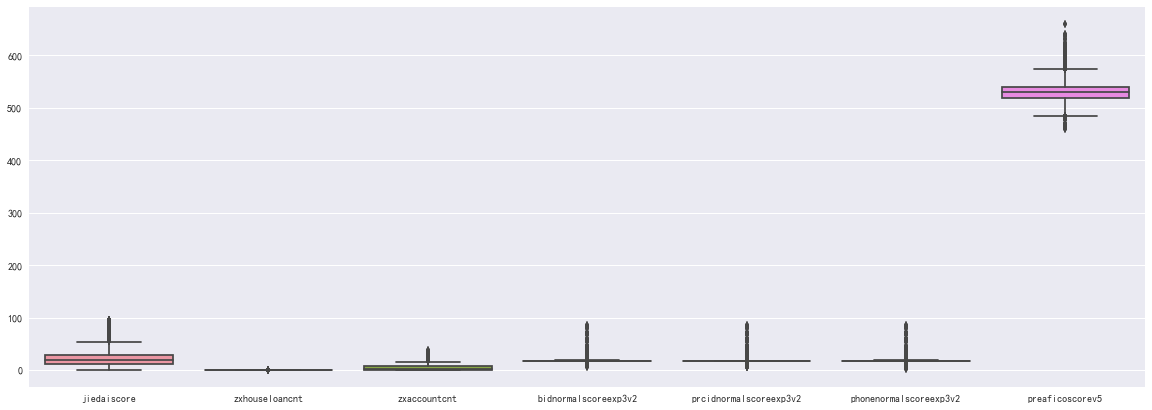

In [251]:
# 筛选连续变量
numeric_cols=['jiedaiscore','zxhouseloancnt','zxaccountcnt','bidnormalscoreexp3v2','prcidnormalscoreexp3v2','phonenormalscoreexp3v2','preaficoscorev5']
num_data_subset = data_set_v1[numeric_cols]

# 展示连续变量的盒子图
plt.figure(figsize=(20,7))
sns.boxplot(data=num_data_subset)

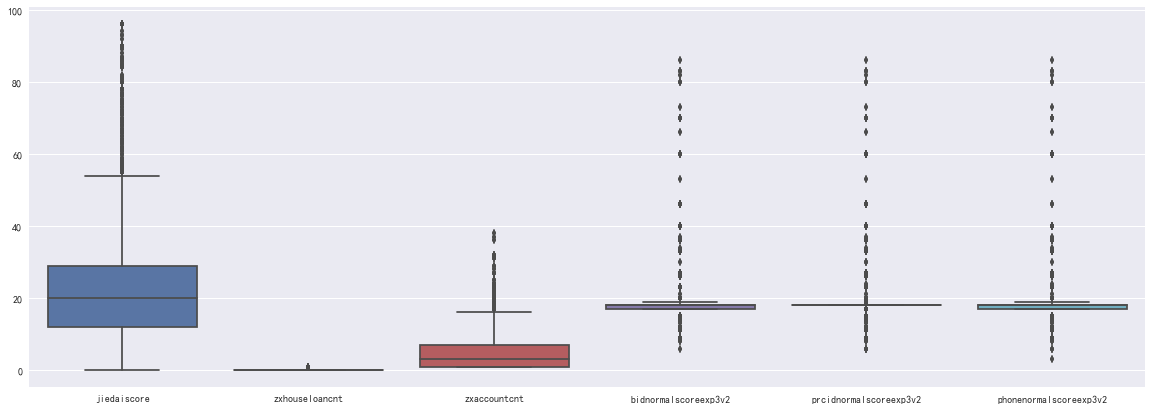

In [252]:
# 筛选连续变量
box_vars=['jiedaiscore','zxhouseloancnt','zxaccountcnt','bidnormalscoreexp3v2','prcidnormalscoreexp3v2','phonenormalscoreexp3v2']
box_data_subset = data_set_v1[box_vars]

# 展示连续变量的盒子图
plt.figure(figsize=(20,7))
sns.boxplot(data=box_data_subset)

**数据解读：**

  * 从连续变量的盒子图可以看出，数据不在一个量级上，需要做归一化处理，特别是preaficoscorev5特征，整体偏高

## [如何标准化](http://scikit-learn.org/stable/modules/preprocessing.html)

In [262]:
# 定义归一化尺度
min_max_scaler = MinMaxScaler()
# 需要归一化的列
feat_cols=['jiedaiscore','zxhouseloancnt','zxaccountcnt','bidnormalscoreexp3v2','prcidnormalscoreexp3v2','phonenormalscoreexp3v2','preaficoscorev5']
# feat_cols=['jiedaiscore']
# 数据特征
X_train = train_data[feat_cols].values
X_test = test_data[feat_cols].values
# 归一化后的数据特征
scaled_X_train = min_max_scaler.fit_transform(X_train)

#将相同的缩放应用到测试集数据中
scaled_X_test = min_max_scaler.transform(X_test)

# 筛选表前列
y_train=train_data['odu_bid'].values
y_test=test_data['odu_bid'].values

# 显示表达式

In [564]:
# 类别特征列
# batch_cols=[x for x in data_set.columns if x.endswith('batch')]
# cut_cols=[x for x in data_set.columns if x.endswith('cut')]
obj_cols=['tongdunblacklevel','blacklisttype']

woe_cols=[x for x in data_set.columns if x.endswith('woe')]
num_cols=['jiedaiscore','zxhouseloancnt','zxaccountcnt','bidnormalscoreexp3v2','prcidnormalscoreexp3v2','phonenormalscoreexp3v2','preaficoscorev5']

num_vars=woe_cols+num_cols
# 分类
data_subset_cat=data_set[obj_cols]
trans_cat_feats=pd.get_dummies(data = data_subset_cat,prefix=data_subset_cat.columns)

# 离散
trans_num_feats=data_set[num_vars]

# 合并数据集：为后续做标准化做准备
data_set_new=pd.concat([trans_cat_feats,trans_num_feats],axis=1)

In [565]:
# 对加工过程中产生的NUll值再次替换为0：保证数据集在入模前没有NULL值
data_set_last=data_set_new.fillna(0)


In [ ]:
logit = sm.Logit(data_set['odu_bid'],data_set_v1).fit()
logit.summary()

In [546]:
a=logit.params
a.sort_values(ascending=False)

zxaccountcnt_woe             1.184279
blacklisttype_D3             1.025458
mobileoperatorregdate_woe    0.685638
age_woe                      0.601548
blacklisttype_D4             0.362359
education_woe                0.080137
tongdunblacklevel_G2         0.003799
phonenormalscoreexp3v2       0.002962
zxaccountcnt                 0.002152
preaficoscorev5             -0.000952
prcidnormalscoreexp3v2      -0.006937
jiedaiscore                 -0.010245
bidnormalscoreexp3v2        -0.012278
zxhouseloancnt              -0.255866
tongdunblacklevel_G3        -0.263530
tongdunblacklevel_G1        -0.310958
blacklisttype_D2            -0.382810
jiedaiscore_woe             -1.061464
dtype: float64

## 刻画人群

In [ ]:
data_set=data_set.drop('bad_feature',1)
# 组合手机入网时间和学历特征
# &(data_set.jiedaiscore_batch=='jiedaiscore_0')
data_set.loc[(data_set.education_batch=='education_0')&(data_set.mobileoperatorregdate_batch=='mobileoperatorregdate_0')&(data_set.zxaccountcnt_batch!='zxaccountcnt_0')&(data_set.city_idx_batch!='city_idx_1'),'bad_feature']='spec_tig'
data_set['bad_feature'].value_counts()

In [ ]:
# 数据整体去重
data_set_dup=data_set.drop_duplicates()
data_set_dup.shape

# 全量
all_apply_sum = data_set_dup['bid'].count()
all_action_sum = data_set_dup['action'].sum()
all_odu_sum = data_set_dup['odu_bid'].sum()
print('整体授信人数：{}，用信人数：{}，逾期人数{}'.format(all_apply_sum, all_action_sum, all_odu_sum))

# 目标人群
apply_sum = data_set_dup[data_set_dup.bad_feature=='spec_tig']['bid'].count()
action_sum = data_set_dup[data_set_dup.bad_feature=='spec_tig']['action'].sum()
odu_sum = data_set_dup[data_set_dup.bad_feature=='spec_tig']['odu_bid'].sum()
print('目标客群授信人数：{}，用信人数：{}，逾期人数{}'.format(apply_sum, action_sum, odu_sum))

In [ ]:
print '召回率：{:.2%}'.format(odu_sum*1.0/all_odu_sum)
print '准确率：{:.2%}'.format(odu_sum*1.0/action_sum)
print '误杀:{:.2%}'.format((action_sum-odu_sum)*1.0/(all_action_sum-all_odu_sum))

# print  '用信人数下降：{:.2%}'.format(932*1.0/5541)
# print  '逾期人数下降：{:.2%}'.format(169*1.0/671)
print '新逾期率：{:.1%}'.format((all_odu_sum-odu_sum)*1.0/(all_action_sum-action_sum))

In [187]:
def inspect_dataset(train_data, test_data):
    print('\n===================== 数据查看 =====================')
    print('训练集有{}条记录。'.format(len(train_data)))
    print('测试集有{}条记录。'.format(len(test_data)))
    # 可视化各类别的数量统计图
    plt.figure(figsize=(10, 5))
    # Train data
    ax1 = plt.subplot(1, 2, 1)
    sns.countplot(x='odu_bid', data=train_data)
    plt.title('Train_data')
    plt.xlabel('odu_bid')
    plt.ylabel('count')
    # Test data
    plt.subplot(1, 2, 2, sharey=ax1)
    sns.countplot(x='odu_bid', data=test_data)
    plt.title('Test_data')
    plt.xlabel('odu_bid')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

In [ ]:
inspect_dataset(train_data, test_data)